# Marketing Analytics Project

---------------------

### Hypothesis

### - Creemos posible entrenar un algoritmo que ofrezca mas de un 70 % de acierto sobre los datos de campañas de marketing de una gran superificie

In [1]:
#https://www.kaggle.com/jackdaoud/marketing-data?select=marketing_data.csv

#https://www.mavenanalytics.io/blog/maven-marketing-challenge?utm_source=linkedin&utm_campaign=marketingchallenge_li_maven

#https://www.kaggle.com/rodsaldanha/arketing-campaign/code

In [1]:
root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)
sys.path = list(set(sys.path)) 

In [2]:
root_path

'c:\\Data_Science_Bootcamp_Kapil\\PythonCurso\\alumno\\MarketingAnalytics_ML_Project'

In [3]:
import pandas as pd
import numpy as np
import sys 
import os 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import src.utils.visualization_tb as vis 
import src.utils.folders_tb as fol
import src.utils.mining_data_tb as mng
import src.utils.models as md

## 2.Data Wrangling

In [5]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(root_path + "\\documentation\\marketing_data.csv")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP


## 4. Data Cleaning

In [6]:
#Dropping ID column
df = df.drop(["ID"], axis=1)
#Dropping Country column
df = df.drop(["Country"], axis=1)
#Dropping MntGoldProds column
df = df.drop(["MntGoldProds"], axis=1)
#Dropping Campaign1 and Campaign2 columns
df = df.drop(["AcceptedCmp1"],axis =1)
df = df.drop(["AcceptedCmp2"],axis =1)
df = df.drop(["AcceptedCmp3"],axis =1)
#Dropping NumDaysLastPurchase column
df = df.drop(["Recency"],axis=1)
#Dropping ComplainLast2Years column
df = df.drop(["Complain"], axis=1)
#Dropping Dt_customer column
df = df.drop(["Dt_Customer"], axis=1)
#Dropping useless information from "Marital_Status" 
df.drop(df[df['Marital_Status'] == "Absurd"].index , inplace=True)
df.drop(df[df['Marital_Status'] == "Alone"].index , inplace=True)
df.drop(df[df['Marital_Status'] == "YOLO"].index , inplace=True)
df.reset_index(inplace = True, drop = True)
#Feature engineering of SUM of "Kidhome" and "Teenhome" into df["KidHome"]
df_ninios = pd.DataFrame([df["Kidhome"], df["Teenhome"]]).transpose()
df_ninios["KidsHome"] = df_ninios.sum(axis=1)
df["KidsHome"] = df_ninios["KidsHome"]
df = df.drop(['Kidhome', 'Teenhome'], axis = 1) 

In [8]:
# #replacing spaces ' ' with _
# k = []
# for i in df["Education"]:
#     i = str(i).replace(' ','_')
#     k.append(i)
# df["Education"] = k

In [7]:
#Renaming Columns
df = df.rename(columns={" Income ":"Income", "NumDealsPurchase": "DiscountPurchases", "NumCatalogPurchases" : "SalesAgentPurchases", "NumWebVisitsMonth":"WebVisitsMonth", "AcceptedCmp3":"Campaign3", "AcceptedCmp4":"Campaign4", "AcceptedCmp5":"Campaign5",
'MntWines':"Wines",'MntFruits':"Fruits", 'MntMeatProducts':"Meat", 'MntFishProducts':"Fish", 'MntSweetProducts':"Sweets",'NumDealsPurchases':"DiscountPurchases", 'NumWebPurchases':"WebPurchases", 'NumStorePurchases':"StorePurchases", "Response":"Campaign3"})

In [8]:
#Transforming Income column (string) to float
df['Income'] = df['Income'].str.replace('$', '')
df['Income'] = df['Income'].str.replace(',', '')
df["Income"]=df["Income"].astype("float")
#Calculating porcentage of missing values per column
miss = df.isnull().sum() * 100 / len(df)
miss
#Filling missing values with mean of the column
df["Income"] = df["Income"].fillna(df["Income"].mean())

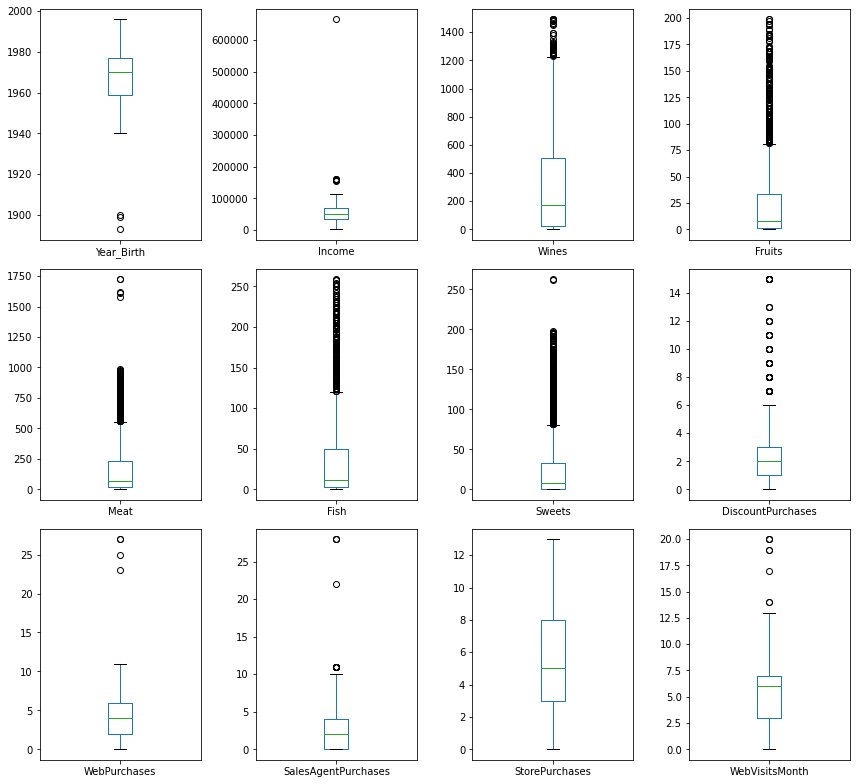

In [9]:
#Checking for outliers
f, axs = plt.subplots(3,4,figsize=(12,11))
df['Year_Birth'].plot(kind='box', ax=axs[0,0])
df['Income'].plot(kind='box', ax=axs[0,1])
df['Wines'].plot(kind='box', ax=axs[0,2])
df['Fruits'].plot(kind='box', ax=axs[0,3])
df['Meat'].plot(kind='box', ax=axs[1,0])
df['Fish'].plot(kind='box', ax=axs[1,1])
df['Sweets'].plot(kind='box', ax=axs[1,2])
df['DiscountPurchases'].plot(kind='box', ax=axs[1,3])
df['WebPurchases'].plot(kind='box', ax=axs[2,0])
df['SalesAgentPurchases'].plot(kind='box', ax=axs[2,1])
df['StorePurchases'].plot(kind='box', ax=axs[2,2])
df['WebVisitsMonth'].plot(kind='box', ax=axs[2,3])
f.tight_layout()
plt.show()

In [10]:
#SOLVING OUTLIER ISSUES:
#Manteniendo las filas con year_birth mayor a 1940
df = df[df["Year_Birth"] > 1940]
#Introducing median value to Income outliers
df.loc[df.Income > 600000,'Income'] = df["Income"].median()

In [11]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Wines,Fruits,Meat,Fish,Sweets,DiscountPurchases,WebPurchases,SalesAgentPurchases,StorePurchases,WebVisitsMonth,Campaign4,Campaign5,Campaign3,KidsHome
0,1970,Graduation,Divorced,84835.0,189,104,379,111,189,1,4,4,6,1,0,0,1,0
1,1961,Graduation,Single,57091.0,464,5,64,7,0,1,7,3,7,5,0,0,1,0
2,1958,Graduation,Married,67267.0,134,11,59,15,2,1,3,2,5,2,0,0,0,1
3,1967,Graduation,Together,32474.0,10,0,1,0,0,1,1,0,2,7,0,0,0,2
4,1989,Graduation,Single,21474.0,6,16,24,11,0,2,3,1,2,7,0,0,1,1


### Preprocessing for Machine Learning:

In [12]:
df_ML = md.encode_OneHot(df=df,column="Education")
df_ML.columns = df_ML.columns.str.replace(' ', '_')
df_ML = md.encode_OneHot(df=df_ML,column="Marital_Status")

In [13]:
df_ML.reset_index(inplace = True, drop = True)

## MACHINE LEARNING:

In [30]:
# Split df into X and y
y = df_ML['Campaign3']
X = df_ML.drop('Campaign3', axis=1)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [40]:
X.columns

Index(['Year_Birth', 'Income', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets',
       'DiscountPurchases', 'WebPurchases', 'SalesAgentPurchases',
       'StorePurchases', 'WebVisitsMonth', 'Campaign4', 'Campaign5',
       'KidsHome', '2n_Cycle', 'Basic', 'Graduation', 'Master', 'PhD',
       'Divorced', 'Married', 'Single', 'Together', 'Widow'],
      dtype='object')

In [43]:
X_train.head()

,Year_Birth,Income,Wines,Fruits,Meat,Fish,Sweets,DiscountPurchases,WebPurchases,SalesAgentPurchases,StorePurchases,WebVisitsMonth,Campaign4,Campaign5,KidsHome,2n_Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow
2154,1960,17144.0,18,2,19,0,2,5,3,0,4,7,0,0,2,0,0,0,1,0,0,0,0,1,0
975,1986,42386.0,65,4,16,0,4,1,3,0,3,8,0,0,1,0,0,0,1,0,0,0,0,1,0
1441,1960,79530.0,333,0,815,129,42,1,4,10,11,2,0,0,0,0,0,1,0,0,0,1,0,0,0
732,1978,37717.0,9,0,6,4,1,1,1,0,2,9,0,0,1,0,0,0,0,1,0,1,0,0,0
1745,1989,46107.0,31,9,27,16,9,1,1,1,4,3,0,0,1,0,0,1,0,0,0,0,1,0,0


In [51]:
yuu = pd.DataFrame(y_train)
yuu.loc[yuu["Campaign3"] == 1,:]

,Campaign3
1696,1
2186,1
105,1
449,1
1330,1
...,...
813,1
895,1
220,1
1851,1


In [44]:
y_traindf.loc[df["gender"] == "M",:]

2154    0
975     0
1441    0
732     0
1745    0
       ..
1646    0
618     0
713     0
219     0
953     0
Name: Campaign3, Length: 1560, dtype: int64

#### LOGISTIC REGRESSION:

In [31]:
### con pca
log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X_train,y_train)
accuracy = log_reg.score(X_test, y_test)
print("accuracy=",accuracy) 

accuracy= 0.8355754857997011


In [32]:
from pickle import dump
# save the model to disk
dump(log_reg, open('finalized_model.sav', 'wb'))

In [36]:
df_csv = df.copy()
df_csv = df.drop('Campaign3', axis=1)
filas_prueba = df_csv.iloc[0:5] #SIN SOLUCIONAR TEMA DE GET_DUMMIES
filas_prueba.to_csv("prueba1.csv",index=False)

In [37]:
df_csv.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'DiscountPurchases', 'WebPurchases',
       'SalesAgentPurchases', 'StorePurchases', 'WebVisitsMonth', 'Campaign4',
       'Campaign5', 'KidsHome'],
      dtype='object')

In [18]:
#df_ML.iloc[509:520].to_csv("loquesea.csv")

In [61]:
# import json
# #LO QUE NOS DIJO GABRIEL PARA EL FLASK DESPEGABLE
# dicc = {}
# for pos,val in enumerate (df["Education"]):
#     dicc[val] = df_ML.loc[pos, "2n Cycle":"PhD"].values
# g = pd.DataFrame(dicc)
# gjson = g.to_json()
# with open("dicc_Education.json", "w") as fp:
#     json.dump(gjson,fp)

import json
diction_Education = {}

array_col = df_ML.loc[:, "2n_Cycle":"PhD"].columns.values
for i,col in enumerate(array_col):
    empty= np.zeros(len(array_col))
    empty[i] = 1
    diction_Education[col] = [int(e) for e in list(empty)]

with open("dicc_Education.json", "w") as fp:
    json.dump(diction_Education,fp)

In [28]:
# dicc1 = {}
# for pos1,val1 in enumerate (df["Marital_Status"]):
#     dicc1[val1] = df_ML.loc[pos1, "Divorced":"Widow"].values
# g1 = pd.DataFrame(dicc1)
# gjson1 = g1.to_json()
# with open("dicc_Marital_status.json", "w") as fp:
#     json.dump(gjson1,fp)

diction_Marital = {}

array_col = df_ML.loc[:, "Divorced":"Widow"].columns.values
for i,col in enumerate(array_col):
    empty= np.zeros(len(array_col))
    empty[i] = 1
    diction_Marital[col] = [int(e) for e in list(empty)]

with open("dicc_Marital.json", "w") as fp1:
    json.dump(diction_Marital,fp1)

In [27]:
### CON GRIDSEARCH
pipe_logistic = Pipeline(steps=[('classifier', LogisticRegression(n_jobs=-1))])

logistic_params = {
    'classifier': [LogisticRegression(n_jobs=-1)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(0, 4, 10)
    }

params_logistic = [logistic_params]

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) 
clf = GridSearchCV(estimator=pipe_logistic,param_grid=params_logistic, cv=cv, verbose=5, n_jobs=-1)
best_model = clf.fit(X_train, y_train)
separator = "\n############################\n"
print(separator)
print("best estimator:", best_model.best_estimator_.get_params()['classifier']) 
print(separator)
print("clf.best_params_", clf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)
print(separator)

Fitting 10 folds for each of 20 candidates, totalling 200 fits

############################

best estimator: LogisticRegression(n_jobs=-1)

############################

clf.best_params_ {'classifier': LogisticRegression(n_jobs=-1), 'classifier__C': 1.0, 'classifier__penalty': 'l2'}

############################

clf.best_score 0.9256410256410257

############################

C:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.92564103        nan 0.92564103        nan 0.92564103
        nan 0.92564103        nan 0.92564103        nan 0.92564103
        nan 0.92564103        nan 0.92564103        nan 0.92564103
        nan 0.92564103]
  warnings.warn(


#### SVC:

In [50]:
svc_lin = SVC(kernel='linear')
svc_lin.fit(X_train,y_train)
accuracy = svc_lin.score(X_test, y_test)
print("accuracy=",accuracy) 

accuracy= 0.9043348281016442


In [ ]:
### CON GRIDSEARCH.NO EJECUTAR ESTO ASÍ TARDA DEMASIADO
pipe_svc = Pipeline(steps=[('classifier', SVC())])

svm_params = {
    'classifier': [SVC()],
    'classifier__kernel':('linear', 'rbf', 'sigmoid'), 
    'classifier__C':[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
    'classifier__degree': np.arange(1, 10),
    'classifier__coef0': [-10.,-1., 0., 0.1, 0.5, 1, 10, 100],
    'classifier__gamma': ('scale', 'auto')
    }
params_svc = [svm_params]

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) 
clf = GridSearchCV(estimator=pipe_svc,param_grid=params_svc, cv=cv, verbose=5, n_jobs=-1)
best_model = clf.fit(X_train, y_train)
separator = "\n############################\n"
print(separator)
print("best estimator:", best_model.best_estimator_.get_params()['classifier']) 
print(separator)
print("clf.best_params_", clf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)
print(separator)

#### RandomForestClassifier:

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, verbose=0, n_jobs=5)
rfc.fit(X_train,y_train)
accuracy = rfc.score(X_test, y_test)
print("accuracy=",accuracy) 

accuracy= 0.9387144992526159


In [ ]:
pipe = Pipeline(steps=[('classifier', RandomForestClassifier())])

random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_features': [1, 2, 3]
    }

params_rforest = [random_forest_params]
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) 
clf = GridSearchCV(estimator=pipe_logistic,param_grid=params_rforest, cv=cv, verbose=5, n_jobs=-1)
best_model = clf.fit(X_train, y_train)
separator = "\n############################\n"
print(separator)
print("best estimator:", best_model.best_estimator_.get_params()['classifier']) 
print(separator)
print("clf.best_params_", clf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)
print(separator)

#### KNN:

In [46]:
#Probe n_neighbors=i de 1 a 20 y el mejor era el 6
model = KNeighborsClassifier(n_neighbors=3)
entrenamiento = model.fit(X_train,y_train)
scores = model.score(X_test, y_test)
print("K = ",i,"Score=",scores)

K =  6 Score= 0.9147982062780269


#### XGBOOST:

In [47]:
model = XGBClassifier() 
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Program Files\Python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9282511210762332

In [ ]:
#POR SI HAGO PCA
# X_pca = X
# pca = PCA(n_components=2)
# pca.fit(X_pca)
# X_pca = pca.transform(X)
# X_pca
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)

## 5. Visualization

### Plots de los siguientes valores con countplot: 
- Education           
- Marital_Status
- Kidhome             
- Teenhome
- Country             
- ComplainLast2Years
- MonthCustomerEnrol  
- YearCustomerEnrol   
- AcceptedCampaign
- WebVisitsMonth

In [57]:
#PLOTTING SEPE
candidatos = ['Education', 'Marital_Status', 'KidsHome', "MonthCustomerEnrol","YearCustomerEnrol", "AcceptedCampaign", "WebVisitsMonth"]
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(nrows=(int(len(candidatos) / 2)), ncols=2 , figsize = (15, 20))
ax = ax.flatten()
for pos, val in enumerate(candidatos):
    sns.countplot(x = val, data = df, ax = ax[pos],palette="rocket") #facecolor='#3d4248'
plt.suptitle('Unique Value Count Plot', y = 1.0, fontsize = 20)
fig.tight_layout()

ValueError: Could not interpret input 'AcceptedCampaign'

### Most sold products:
- MntWines         
- MntFruits
- MntMeatProducts  
- MntFishProducts 
- MntSweetProducts
- MntGoldProds

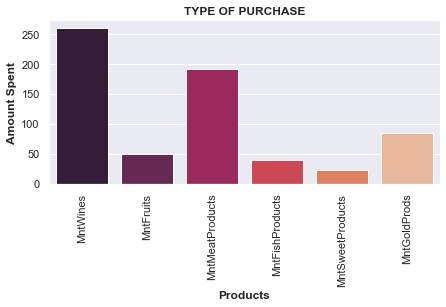

In [22]:
#groupby_data = data_final.groupby("location").mean().sort_values(by="location")
cols = ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
datos = df.copy()
def media_columnas(data,cols):
    lista = []
    for pos,val in enumerate(cols):
        lista.append(data[val].mean())
    return lista

lista = media_columnas(data=datos,cols=cols)

#Creating dataframe to plot values
list_of_tuples = list(zip(cols, lista))   
df_MntProducts = pd.DataFrame(list_of_tuples, columns = ['Products', 'MeanAmountSpent'])  
df_MntProducts

# cant_dif = df.Race.value_counts(normalize=True)
# cant_dif.index = ['White', 'Black', 'Hispanic', 'Asian', 'Native American',"Other"]
ax = plt.figure(figsize=(7,3))
ax = sns.barplot(x=df_MntProducts["Products"], y=df_MntProducts["MeanAmountSpent"],palette="rocket")
plt.title("TYPE OF PURCHASE", fontdict={"fontweight":"bold"})
plt.xlabel("Products", fontdict={"fontweight":"bold"})
plt.ylabel("Amount Spent", fontdict={"fontweight":"bold"})
plt.xticks(rotation="90")
    #plt.savefig(root_path + "\\resources\\total_race.png")
plt.show()

### DIFFERENT WAYS OF PURCHASES:
- NumDealsPurchases
- NumWebPurchases
- NumSalesAgentPurchases
- NumStorePurchases

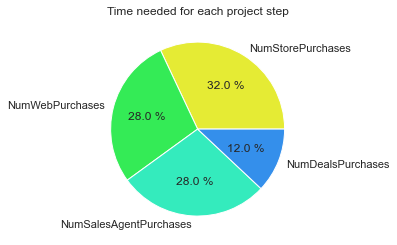

In [23]:
cols1 = ["NumDealsPurchases","NumWebPurchases","NumSalesAgentPurchases","NumStorePurchases"]
datos1 = df.copy()
def suma_total_columnas(data,cols):
    lista1 = []
    for pos,val in enumerate(cols):
        lista1.append(data[val].sum())
    return lista1

lista1 = suma_total_columnas(data=datos1,cols=cols1)

#Creating dataframe to plot values
list_of_tuples1 = list(zip(cols1, lista1))   
df_purchases = pd.DataFrame(list_of_tuples1, columns = ['Purchase_Type', 'TotalPurchase'])  
df_purchases = df_purchases.sort_values("TotalPurchase",ascending=False)

#Grafica
colors = ["#3F0245","#7A2D81", "#A56AAB", "#C197C6", "#E9D9EB"]
plt.pie(df_purchases["TotalPurchase"], labels= df_purchases["Purchase_Type"],colors=colors, autopct="%.1f %%")  
plt.title("Time needed for each project step")
#plt.savefig(root_path + "\\resources\\project_step_time.png")
plt.show()

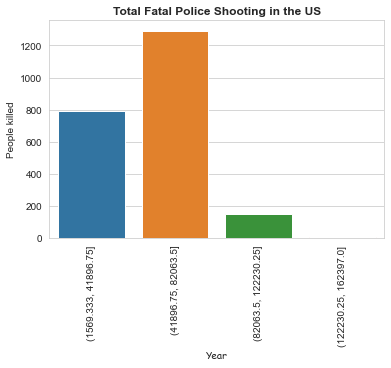

In [12]:
#YA NO VOY A PODER HACER ESTO PORQUE HE ELIMINADO LOS RANGOS POR SIMPLIFICAR
#PLOT DE GRUPOS DE PERSONAS POR SUELDO
g_bin=df.groupby(df["Income_rangos"]).count()
ax = plt.figure()
sns.set_style("whitegrid")
ax = sns.barplot(x=g_bin.index, y=g_bin["Income"])
plt.title("Total Fatal Police Shooting in the US", fontdict={"fontweight":"bold"})
plt.xlabel("Year", fontdict={"fontname":"Comic Sans MS"})
plt.ylabel("People killed")
plt.xticks(rotation="90")
plt.show()

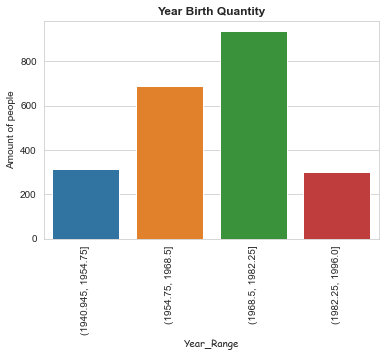

In [21]:
#PLOT DE GRUPOS DE PERSONAS POR AÑO DE NACIMIENTO
g_bin=df.groupby(df["Year_Birth_Range"]).count()
ax = plt.figure()
sns.set_style("whitegrid")
ax = sns.barplot(x=g_bin.index, y=g_bin["Year_Birth"])
plt.title("Year Birth Quantity", fontdict={"fontweight":"bold"})
plt.xlabel("Year_Range", fontdict={"fontname":"Comic Sans MS"})
plt.ylabel("Amount of people")
plt.xticks(rotation="90")
plt.show()

### NORMALIZAR = STANDARDSCALER() O MINMAXSCALER() - MEJORA EL SCORE AUNQUE SE PUEDE HACER SIN EL 

### PCA:

In [ ]:
#PROBAR DIFERENTES COLUMNAS CON PCA PARA ENCONTRAR ALGUNOS DE LOS DATOS
#es una cosa mas a probar para conseguir un mejor Score en ML
#alumno\Kap_Git\week10\day3\theory\PCA.ipynb
#lo suyo es entrenar el modelo con todas las columnas y luego entrenar el modelo con las dos columnas que me salen del PCA y vemos si aumenta el score, quiere decir que la distribucion de 2 ejes, encuentra mas patrones que con 4 ejes

#HACER ESTO DESPUES DE ENTRENAR A MI MODELO CON LOS ALGORITMOS


In [ ]:
# CREO QUE LO MEJOR ES NO HACER LABEL ENCODER Y HACER GET_DUMMIES
# le = preprocessing.LabelEncoder()
# y_label_encoded = le.fit_transform(y)
# X = np.array(X)
# y = np.array(y_label_encoded)

In [ ]:
#What to do with category columns for machine learning? LABELENCODER?

In [ ]:
#Encoding Dtype=Category columns (Income_rangos, Year_Birth_Range)

In [26]:
#Estamos haciendo labelencoder pero ¿Se pone 1 al conjunto más bajo y 4 al conjunto más alto? O Esto lo tenemos que hacer manualmente
le = preprocessing.LabelEncoder()
le_Income_Rangos = le.fit_transform(df["Income_rangos"])

In [19]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Wines,Fruits,Meat,Fish,Sweets,DiscountPurchases,WebPurchases,SalesAgentPurchases,StorePurchases,WebVisitsMonth,Campaign4,Campaign5,Campaign3,KidsHome,Income_rangos,Year_Birth_Range
0,1970,Graduation,Divorced,84835.0,189,104,379,111,189,1,4,4,6,1,0,0,1,0,"(82063.5, 122230.25]","(1968.5, 1982.25]"
1,1961,Graduation,Single,57091.0,464,5,64,7,0,1,7,3,7,5,0,0,1,0,"(41896.75, 82063.5]","(1954.75, 1968.5]"
2,1958,Graduation,Married,67267.0,134,11,59,15,2,1,3,2,5,2,0,0,0,1,"(41896.75, 82063.5]","(1954.75, 1968.5]"
3,1967,Graduation,Together,32474.0,10,0,1,0,0,1,1,0,2,7,0,0,0,2,"(1569.333, 41896.75]","(1954.75, 1968.5]"
4,1989,Graduation,Single,21474.0,6,16,24,11,0,2,3,1,2,7,0,0,1,1,"(1569.333, 41896.75]","(1982.25, 1996.0]"


In [20]:
df_PRUEBA = df.copy()

In [21]:
lista_recorrer =  list(df_PRUEBA["Education"].unique())
lista_recorrer

['Graduation', 'PhD', '2n Cycle', 'Master', 'Basic']

In [33]:
for i in lista_recorrer:
    df_PRUEBA[i] = 0

In [35]:
lista_recorrer =  list(df_PRUEBA["Education"].unique())
lista_recorrer

['Graduation', 'PhD', '2n Cycle', 'Master', 'Basic']

In [39]:
for pos,val in enumerate(df_PRUEBA["Education"]):
    if val in lista_recorrer:
        df_PRUEBA[val][pos] = 1